In [67]:
import os
os.environ['http_proxy'] = "http://192.41.170.23:3128" 
os.environ['https_proxy'] = "http://192.41.170.23:3128" 

# export http_proxy=http://192.41.170.23:3128
# export https_proxy=http://192.41.170.23:3128

# 02. Neural Network Classification with PyTorch

Classification is prediciting whether something is one thing or another (or another).

## 1. Make classification data and get it ready



In [68]:
!nvidia-smi

Sun Jun  4 07:22:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000                Off| 00000000:01:00.0 Off |                  Off |
| 66%   85C    P2              303W / 300W|  42358MiB / 49140MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [69]:
import sklearn

from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [70]:
len(X), len(y)

(1000, 1000)

In [71]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [72]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


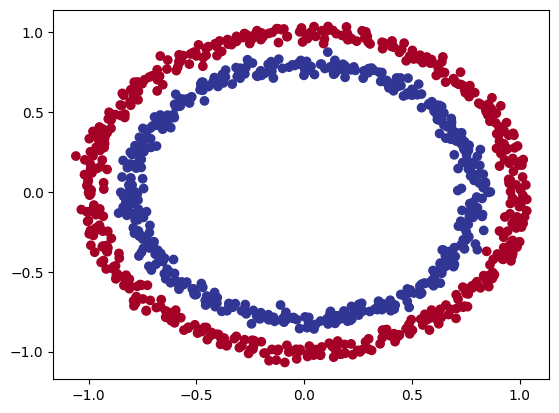

In [73]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [74]:
X.shape, y.shape

((1000, 2), (1000,))

In [75]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [76]:
# View the first exemplar of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [77]:
import torch
torch.__version__

'2.0.1+cu117'

In [78]:
type(X)

numpy.ndarray

In [79]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)



In [80]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [81]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [82]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on a GPU if there is one
2. Construct a model by subclassing `nn.Module`
3. Define a loss function and optimizer
4. Create a training and test loop
  

In [83]:
import torch
from torch import nn

# Make device-agnostic ode
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [84]:
X_train.shape

torch.Size([800, 2])

In [85]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)
    
  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
  
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [86]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [87]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [88]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [89]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again, this is problem specific.

For exemplar, for regression, you might want MAE or MSE.

For classification, you might want binary cross entropy or cross entropy.

As a reminder, the loss function measures how *wrong* your model's predictions are.

For optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`

In [90]:
# Setup the loss function

# nn.Sequential(
#   nn.Sigmoid(),   same as below
#   nn.BCELoss()
# )

loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [91]:
# Calculate accuracy - out of 100 exemplars, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits to prediction probabilities to prediction labels

Our model outputs are going to be raw **logits**.

We can covert these logits into prediction probabilities by passing them into some kind of activation function e.g. sigmoid for binary cross entropy or softmax for multiclass classification.

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.


In [92]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [93]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [94]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probabiltity values, we need to perform a range-style rounding on them:
  
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [95]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [96]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and eval loop
for epoch in range(epochs):
  ### Training
  model_0.train()
  
  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels
  
  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #                y_train)
  loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()
  
  # 4. Loss backward
  loss.backward()
  
  # 5. Optimizer step
  optimizer.step()
  
  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    # 2. Calculate test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_accuracy = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
    
  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss}, Acc: {acc} | Test loss {test_loss}, Test acc: {test_accuracy}")

Epoch: 0 | Loss: 0.6979604959487915, Acc: 51.87500000000001 | Test loss 0.6943961381912231, Test acc: 57.99999999999999
Epoch: 10 | Loss: 0.6958984136581421, Acc: 51.24999999999999 | Test loss 0.6930527091026306, Test acc: 53.0
Epoch: 20 | Loss: 0.6949015855789185, Acc: 51.625 | Test loss 0.692543625831604, Test acc: 49.5
Epoch: 30 | Loss: 0.6943498253822327, Acc: 51.125 | Test loss 0.6923599243164062, Test acc: 49.5
Epoch: 40 | Loss: 0.6940091252326965, Acc: 50.875 | Test loss 0.6923156380653381, Test acc: 51.0
Epoch: 50 | Loss: 0.6937821507453918, Acc: 50.24999999999999 | Test loss 0.6923370361328125, Test acc: 50.0
Epoch: 60 | Loss: 0.6936231851577759, Acc: 50.0 | Test loss 0.6923912763595581, Test acc: 51.5
Epoch: 70 | Loss: 0.6935079097747803, Acc: 50.24999999999999 | Test loss 0.6924624443054199, Test acc: 51.0
Epoch: 80 | Loss: 0.6934223175048828, Acc: 49.875 | Test loss 0.6925414800643921, Test acc: 50.0
Epoch: 90 | Loss: 0.6933572888374329, Acc: 49.875 | Test loss 0.6926234364

## 4. Make predictions and evaluate the model

From the metric, it looks like our model isn't learning anything.

So to inspect it, let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()`

In [97]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


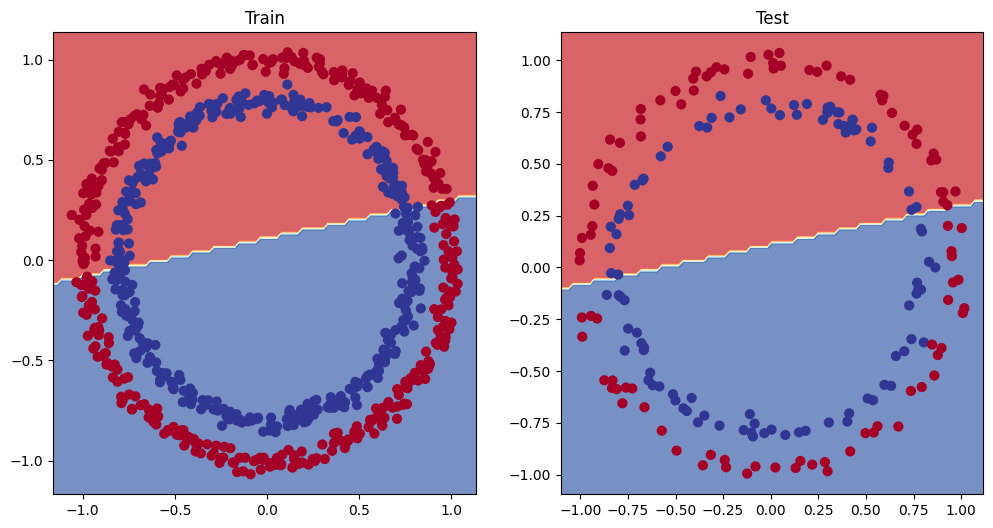

In [98]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal with the model rather than the data.

They are referred to as **hyperparameters**.

Let's try to improve by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [99]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1.], device='cuda:0'))

In [100]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed
  
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [101]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [102]:
# Write a training and evalutaion loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on target deivce
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels
  
  # 2. Calculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()
  
  # 4. Loss backwards
  loss.backward()
  
  # 5. Optimizer step
  optimizer.step()
  
  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                          y_pred=test_pred)
    
    # Print what happen
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss}, Acc: {acc} | Test loss: {test_loss}, Test acc: {test_acc}")

Epoch: 0 | Loss: 0.6939550638198853, Acc: 50.875 | Test loss: 0.6926146745681763, Test acc: 51.0
Epoch: 100 | Loss: 0.6930478811264038, Acc: 50.375 | Test loss: 0.6937904357910156, Test acc: 48.0
Epoch: 200 | Loss: 0.6929859519004822, Acc: 51.125 | Test loss: 0.6943727135658264, Test acc: 46.0
Epoch: 300 | Loss: 0.6929804682731628, Acc: 51.625 | Test loss: 0.6945767998695374, Test acc: 45.0
Epoch: 400 | Loss: 0.6929798722267151, Acc: 51.125 | Test loss: 0.6946452260017395, Test acc: 46.0
Epoch: 500 | Loss: 0.6929798722267151, Acc: 51.0 | Test loss: 0.6946680545806885, Test acc: 46.0
Epoch: 600 | Loss: 0.6929798722267151, Acc: 51.0 | Test loss: 0.6946756839752197, Test acc: 46.0
Epoch: 700 | Loss: 0.6929798722267151, Acc: 51.0 | Test loss: 0.6946782469749451, Test acc: 46.0
Epoch: 800 | Loss: 0.6929798722267151, Acc: 51.0 | Test loss: 0.6946790814399719, Test acc: 46.0
Epoch: 900 | Loss: 0.6929798722267151, Acc: 51.0 | Test loss: 0.6946793794631958, Test acc: 46.0


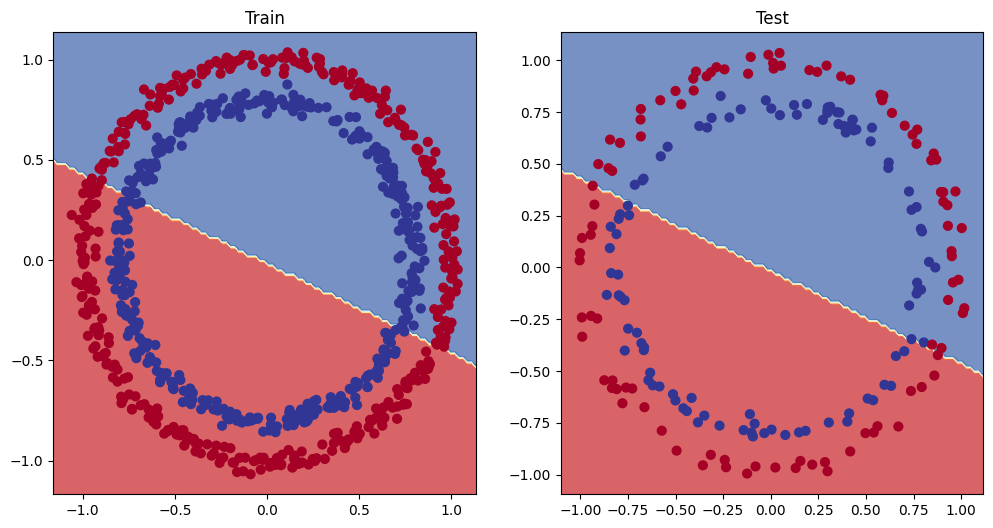

In [103]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can predict a straight line

One way to troubleshoot a larger problem is to fit a smaller problem.

In [104]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3

X_regression = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [105]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_test_regression)

(80, 20)

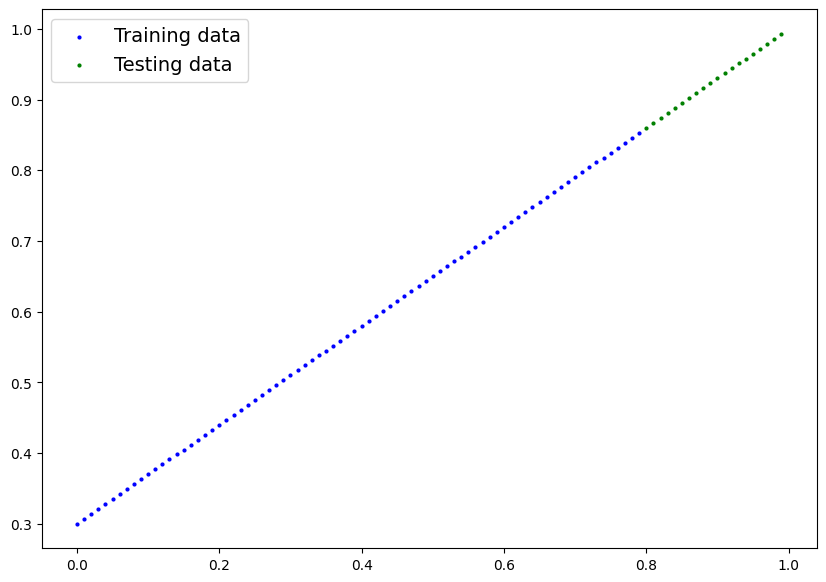

In [106]:

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);


### 5.2 Adjusting `model_1` to fit a straight line



In [107]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
  nn.Linear(in_features=1, out_features=10),
  nn.Linear(in_features=10, out_features=10),
  nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [108]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [109]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)
    
  # Print out what happen
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.7598585486412048 | Test loss: 0.9110288619995117
Epoch: 100 | Loss: 0.02857951633632183 | Test loss: 0.0008127153269015253
Epoch: 200 | Loss: 0.025325417518615723 | Test loss: 0.002092081354930997
Epoch: 300 | Loss: 0.021374845877289772 | Test loss: 0.0030510486103594303
Epoch: 400 | Loss: 0.01964494027197361 | Test loss: 0.003407770534977317
Epoch: 500 | Loss: 0.01940225623548031 | Test loss: 0.0038725913036614656
Epoch: 600 | Loss: 0.019032439216971397 | Test loss: 0.0037890970706939697
Epoch: 700 | Loss: 0.01878299191594124 | Test loss: 0.003813520073890686
Epoch: 800 | Loss: 0.01839751936495304 | Test loss: 0.003287535859271884
Epoch: 900 | Loss: 0.017980331555008888 | Test loss: 0.003603857709094882


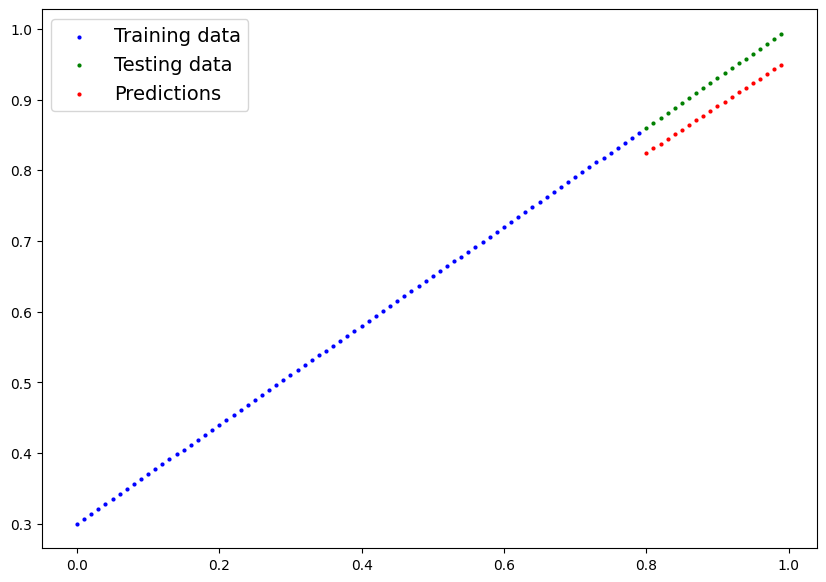

In [110]:
# Turn on evaluation mode 
model_2.eval()

# Make inferences
with torch.inference_mode():
  y_preds = model_2(X_test_regression)
  
# Plot data and preds
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(), 
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

### 6.1 Recreating non-linear data (red and blue circles)

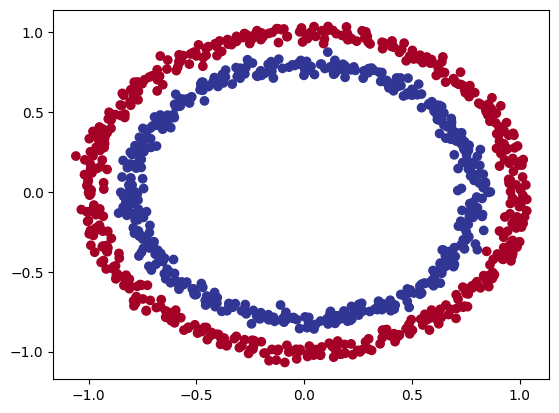

In [127]:
# Make and plot data
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [128]:
# Convert to tensor and split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

# 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

ANNs are a combination of linear and non-linear functions that are able to find patterns in data.

In [129]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self, x):
    # where should we put the nonlinearity
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
  
  
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [130]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), 
                            lr=0.1)

# spam or not spam, credit card fraud, insurance claim, e.g.

### 6.3 Training a model with non-linearity


In [142]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all daata on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop thru data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()
  
  # 1. Forward Pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  
  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()
  
  # 4. Loss backward
  loss.backward()
  
  # 5. Gradient Descent Step Optimizer
  optimizer.step()
  
  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)
    
    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss}, Acc: {acc} | Test loss: {test_loss}, Test Acc: {test_acc}")
  

Epoch: 0 | Loss: 0.003004463855177164, Acc: 100.0 | Test loss: 0.012727524153888226, Test Acc: 99.5
Epoch: 100 | Loss: 0.0029750834219157696, Acc: 100.0 | Test loss: 0.01268907729536295, Test Acc: 99.5
Epoch: 200 | Loss: 0.002946289721876383, Acc: 100.0 | Test loss: 0.012651764787733555, Test Acc: 99.5
Epoch: 300 | Loss: 0.002918040147051215, Acc: 100.0 | Test loss: 0.012615080922842026, Test Acc: 99.5
Epoch: 400 | Loss: 0.002890336560085416, Acc: 100.0 | Test loss: 0.012579229660332203, Test Acc: 99.5
Epoch: 500 | Loss: 0.0028631575405597687, Acc: 100.0 | Test loss: 0.012543934397399426, Test Acc: 99.5
Epoch: 600 | Loss: 0.0028364930767565966, Acc: 100.0 | Test loss: 0.01250969897955656, Test Acc: 99.5
Epoch: 700 | Loss: 0.0028103154618293047, Acc: 100.0 | Test loss: 0.012476426549255848, Test Acc: 99.5
Epoch: 800 | Loss: 0.0027846284210681915, Acc: 100.0 | Test loss: 0.012443512678146362, Test Acc: 99.5
Epoch: 900 | Loss: 0.002759396331384778, Acc: 100.0 | Test loss: 0.01240503508597

## 6.4 Evaluating a model trained with non-linear activations


In [143]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10] 

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

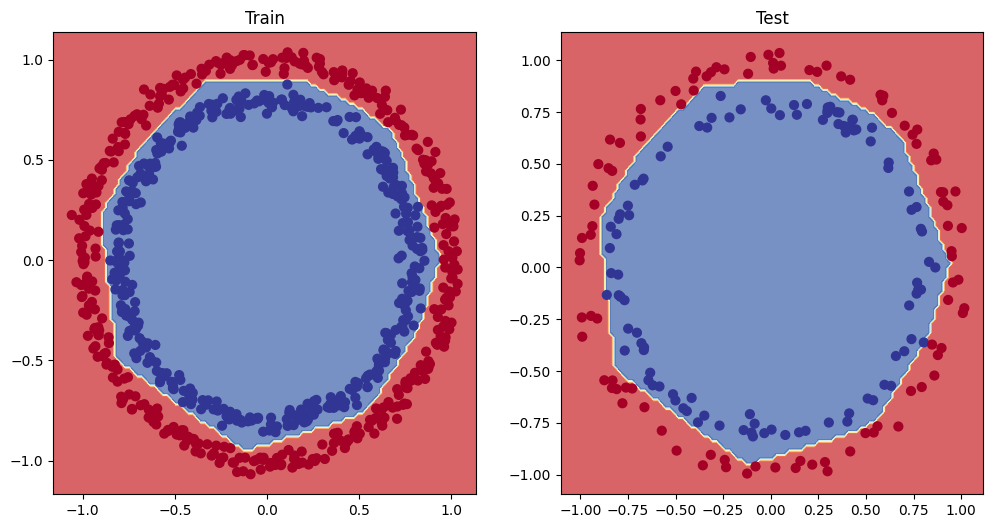

In [144]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity


## 7. Replicating non-linear activation functions

Rather than us telling the model to learn, we give it the tools to discover patterns in data and it tries to figure out best patterns on its own.

And these tools are linear and non linear functions.

In [118]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)


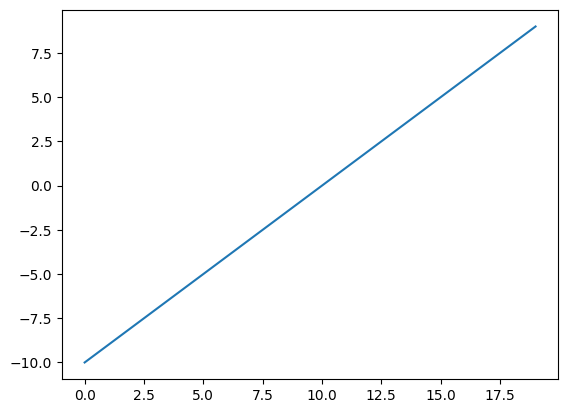

In [119]:
# Visualize the tensor
plt.plot(A);

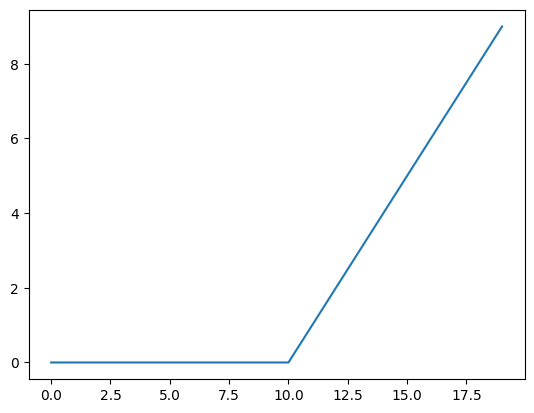

In [120]:
plt.plot((torch.relu(A)))

In [121]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

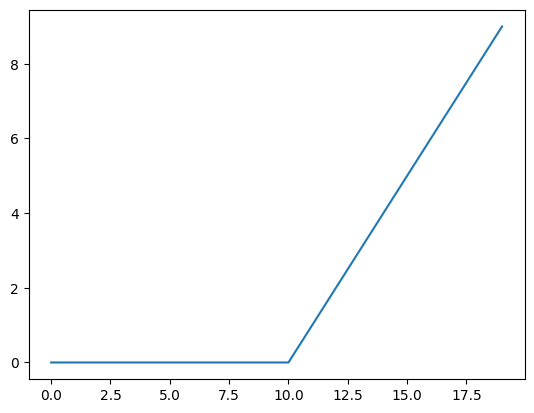

In [122]:
# Plot ReLY activation function
plt.plot(relu(A));

In [123]:
# Now let's do the same for sigmoid
def sigmoid(x):
    return 1/(1+torch.exp(-x))



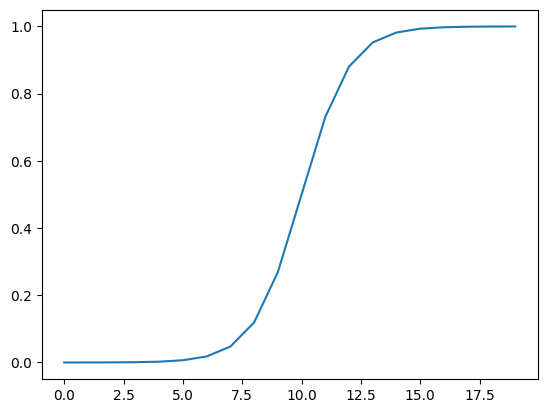

In [124]:
plt.plot(torch.sigmoid(A))

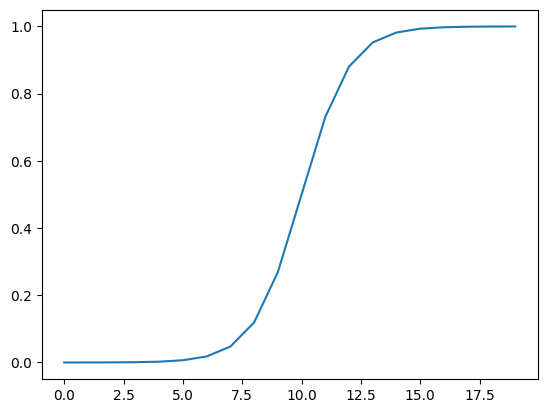

In [125]:
plt.plot(sigmoid(A))

## 8. Putting it all together with multi class problem

* Binary classification = one thing or another
* Multi-class classification = more than one thing or another

### Creating a toy multi-class dataset

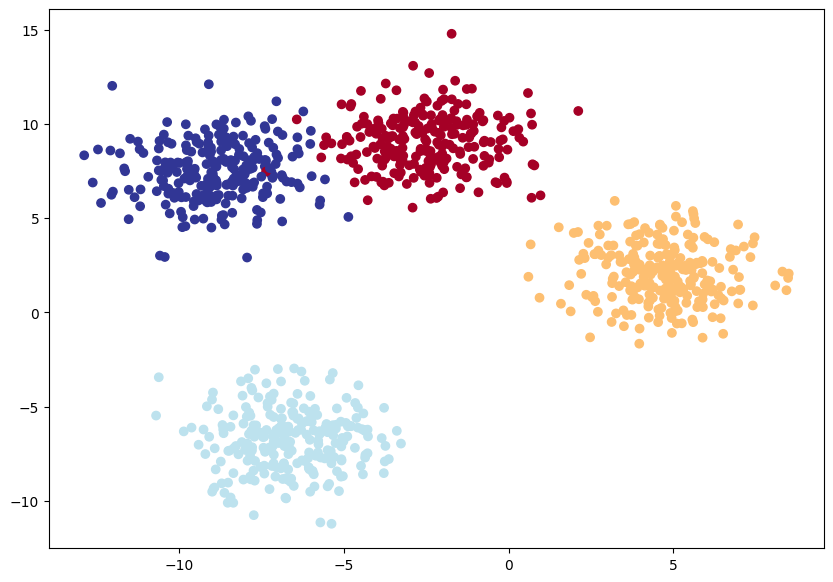

In [175]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparamters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                             n_features=NUM_FEATURES,
                             centers=NUM_CLASSES,
                             cluster_std=1.5,
                             random_state=RANDOM_SEED)

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data (visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


### 8.2 Building a multi-class classification model in PyTorch

In [176]:
# Create device-agnostic code
devicce = "cude" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [177]:
# Build a multi-class classificaition model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args: 
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_features)
    )
    
  def forward(self, x):
    return self.linear_layer_stack(x)


# Create an instance of blob model and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for multi-class classification model

In [178]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the pred probs)

In [179]:
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [180]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [181]:
# convert logit outputs to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [182]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [183]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

In [184]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [185]:
# Convert our model's prediction probabilities to labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [186]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [189]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop thrrough data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_preds)

  # Print out what goes on
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss}, Acc: {acc} | Test loss: {test_loss}, Test acc: {test_acc}")



Epoch: 0 | Loss: 0.03294935077428818, Acc: 99.25 | Test loss: 0.024132560938596725, Test acc: 99.5
Epoch: 10 | Loss: 0.03146691620349884, Acc: 99.25 | Test loss: 0.02245824597775936, Test acc: 99.5
Epoch: 20 | Loss: 0.030345911160111427, Acc: 99.25 | Test loss: 0.021146712824702263, Test acc: 99.5
Epoch: 30 | Loss: 0.02950405143201351, Acc: 99.25 | Test loss: 0.02013082057237625, Test acc: 99.5
Epoch: 40 | Loss: 0.028831806033849716, Acc: 99.25 | Test loss: 0.01932380720973015, Test acc: 99.5
Epoch: 50 | Loss: 0.02828352525830269, Acc: 99.25 | Test loss: 0.018659016117453575, Test acc: 99.5
Epoch: 60 | Loss: 0.02782589942216873, Acc: 99.25 | Test loss: 0.018101835623383522, Test acc: 99.5
Epoch: 70 | Loss: 0.027435431256890297, Acc: 99.25 | Test loss: 0.017620466649532318, Test acc: 99.5
Epoch: 80 | Loss: 0.027098525315523148, Acc: 99.25 | Test loss: 0.017192665487527847, Test acc: 99.5
Epoch: 90 | Loss: 0.026805007830262184, Acc: 99.25 | Test loss: 0.016816886141896248, Test acc: 99.5

### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [190]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -0.8275,   7.4320,  -8.6558,  -9.6514],
        [ -2.4389,  -7.2588,  -4.4828,   4.0251],
        [ -4.1976,  -4.6293,   3.9776,  -3.1901],
        [ -1.4920,   5.2994,  -4.4653,  -5.5549],
        [  4.8249,  -1.4429, -10.3200,  -8.0009],
        [ -3.1223,  -8.6489,  -5.1848,   4.7896],
        [ -3.7167,  -3.9705,   3.5040,  -2.6376],
        [  4.3045,  -4.6910,  -7.8507,  -4.0628],
        [ -5.3417,  -5.9122,   4.8492,  -4.1046],
        [  4.4872,  -3.4761,  -8.5520,  -5.3956]], device='cuda:0')

In [191]:
# Go from logits to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.5871e-04, 9.9974e-01, 1.0305e-07, 3.8076e-08],
        [1.5557e-03, 1.2551e-05, 2.0150e-04, 9.9823e-01],
        [2.8122e-04, 1.8262e-04, 9.9877e-01, 7.7016e-04],
        [1.1221e-03, 9.9880e-01, 5.7379e-05, 1.9299e-05],
        [9.9810e-01, 1.8928e-03, 2.6414e-07, 2.6854e-06],
        [3.6619e-04, 1.4573e-06, 4.6555e-05, 9.9959e-01],
        [7.2878e-04, 5.6544e-04, 9.9656e-01, 2.1440e-03],
        [9.9964e-01, 1.2392e-04, 5.2590e-06, 2.3226e-04],
        [3.7502e-05, 2.1198e-05, 9.9981e-01, 1.2922e-04],
        [9.9960e-01, 3.4786e-04, 2.1726e-06, 5.1023e-05]], device='cuda:0')

In [192]:
# Go from pred probs to pred labels
y_preds = y_pred_probs.argmax(dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [193]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

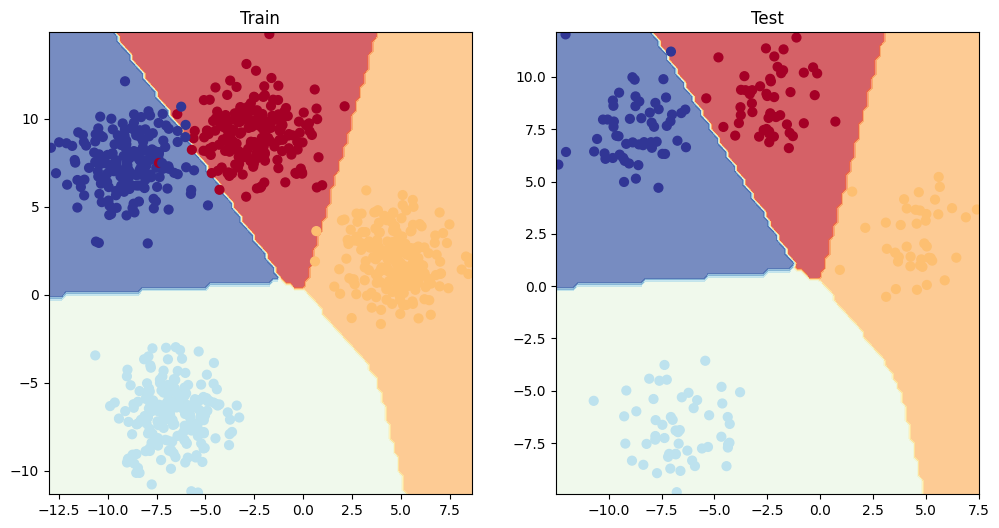

In [194]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy = Out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matric
* Classification report

See TorchMetrics

In [200]:
from torchmetrics import Accuracy

# Setup metrics
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [201]:
!nvidia-smi

Mon Jun  5 03:58:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000                Off| 00000000:01:00.0 Off |                  Off |
| 30%   36C    P8               26W / 300W|   1058MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Exercises

### 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors.
* Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [12]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons
import torch
X, y = make_moons(n_samples=1000, noise=0.15, random_state=42)

In [13]:
# Turn data into a DataFrame
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
                     "X2": X[:, 1],
                      "label": y})

moons[:10]

,X1,X2,label
0,-0.081568,0.482211,1
1,1.087333,-0.381159,1
2,0.831725,-0.133135,1
3,0.200339,-0.500300,1
4,-0.824953,0.539526,0
5,0.638108,-0.163363,1
6,0.280502,-0.195590,1
7,-0.085830,0.506496,1
8,1.588293,-0.319494,1
9,0.736816,0.910613,0


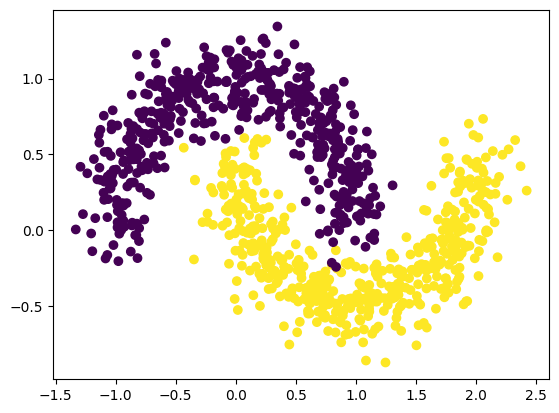

In [14]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)

In [15]:
# Turn data into tensors of dtype float
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)

print(X.dtype, y.dtype)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

torch.float32 torch.float32


In [17]:
device = "cuda" if torch.cuda.is_available() else "spu"
device

'cuda'

In [18]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.* 
Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [19]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
  def __init__(self, in_features, out_features, hidden_features=8):
    super().__init__()
    self.linear_layer_stackV1 = nn.Sequential(
      nn.Linear(in_features=in_features, out_features=hidden_features),
      nn.ReLU(),
      nn.Linear(in_features=hidden_features, out_features=hidden_features),
      nn.ReLU(),
      nn.Linear(in_features=hidden_features, out_features=out_features)
    )

  def forward(self, x):
    return self.linear_layer_stackV1(x)

# Instantiate the model
model_5 = MoonModelV0(in_features=2, out_features=1).to(device)
model_5

MoonModelV0(
  (linear_layer_stackV1): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

### 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [20]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(model_5.parameters(), lr=0.1)

### 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1

* To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.acy.

In [21]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
print(model_5(X_train[:10]))

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_5(X_train[:10])))

# Prediction labels
print("Pred labels:")
print(torch.round(torch.sigmoid(model_5(X_train[:10]))))

Logits:
tensor([[-0.1019],
        [-0.1881],
        [-0.1513],
        [-0.1421],
        [-0.0972],
        [-0.1590],
        [-0.1061],
        [-0.0934],
        [-0.0958],
        [-0.0958]], device='cuda:0', grad_fn=<AddmmBackward0>)
Pred probs:
tensor([[0.4746],
        [0.4531],
        [0.4622],
        [0.4645],
        [0.4757],
        [0.4603],
        [0.4735],
        [0.4767],
        [0.4761],
        [0.4761]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)


In [22]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
# !pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [23]:
## TODO: Uncomment this to set the seed
torch.manual_seed(42)

# Setup epochs
epochs = 1000

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_5.train()

  # 1. Forward pass (logits output)
  y_logits = model_5(X_train).squeeze()
  # Turn logits into prediction probabilities
  y_pred_probs = torch.sigmoid(y_logits)
  # Turn prediction probabilities into prediction labels
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()
  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
  optimizer.step()

  ### Testing
  model_5.eval() 
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_5(X_test).squeeze()
    # Turn the test logits into prediction labels
    test_preds = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(y_test, test_preds)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss}, Acc: {acc} | Test loss: {test_loss}, Test acc: {test_acc}")

Epoch: 0 | Loss: 0.685113787651062, Acc: 0.5 | Test loss: 0.6840681433677673, Test acc: 0.5
Epoch: 100 | Loss: 0.3493676781654358, Acc: 0.8537499904632568 | Test loss: 0.35948848724365234, Test acc: 0.8500000238418579
Epoch: 200 | Loss: 0.277685284614563, Acc: 0.8737499713897705 | Test loss: 0.2760724723339081, Test acc: 0.8550000190734863
Epoch: 300 | Loss: 0.2704235911369324, Acc: 0.8787500262260437 | Test loss: 0.26540857553482056, Test acc: 0.8600000143051147
Epoch: 400 | Loss: 0.2657706141471863, Acc: 0.8799999952316284 | Test loss: 0.2599090039730072, Test acc: 0.8650000095367432
Epoch: 500 | Loss: 0.2577611804008484, Acc: 0.8837500214576721 | Test loss: 0.2514868378639221, Test acc: 0.8799999952316284
Epoch: 600 | Loss: 0.24436011910438538, Acc: 0.8912500143051147 | Test loss: 0.2370901256799698, Test acc: 0.9049999713897705
Epoch: 700 | Loss: 0.22313731908798218, Acc: 0.9024999737739563 | Test loss: 0.21479812264442444, Test acc: 0.9100000262260437
Epoch: 800 | Loss: 0.19147960

### 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [24]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

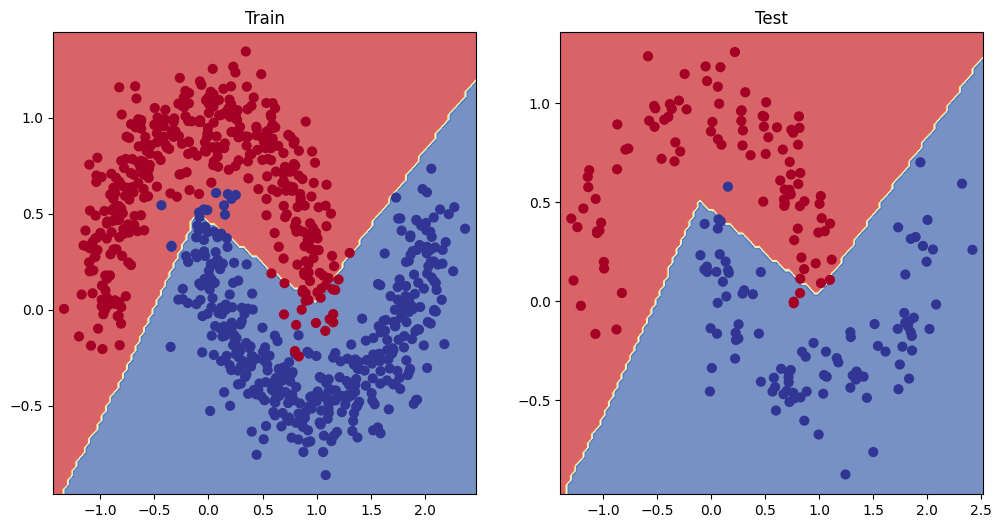

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_test, y_test)

### 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
* Feel free to reference the ML cheatsheet website for the formula.

In [26]:
# Create a straight line tensor
a = torch.arange(-10, 10, 0.2)

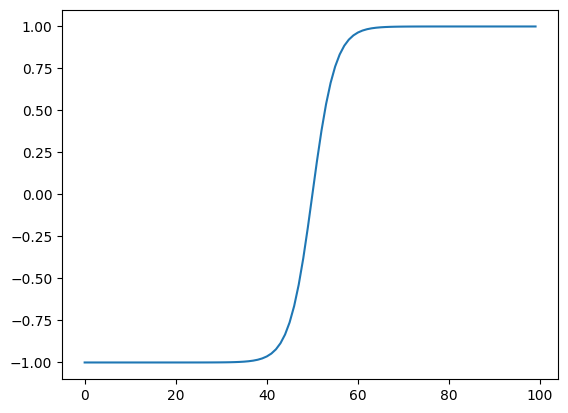

In [27]:
# Test torch.tanh() on the tensor and plot it
b = torch.tanh(a)
plt.plot(b)

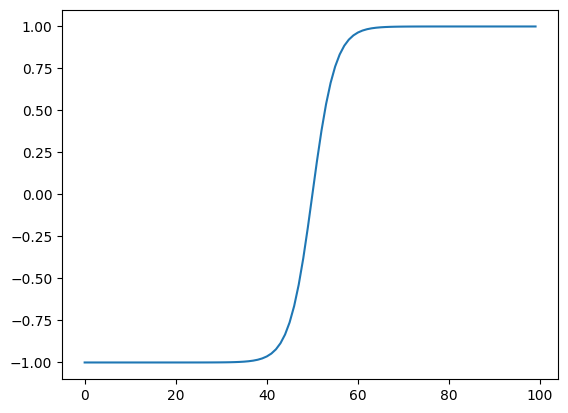

In [28]:
# Replicate torch.tanh() and plot it
def tanh(x):
  return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))

plt.plot(tanh(a))

### 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
* Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

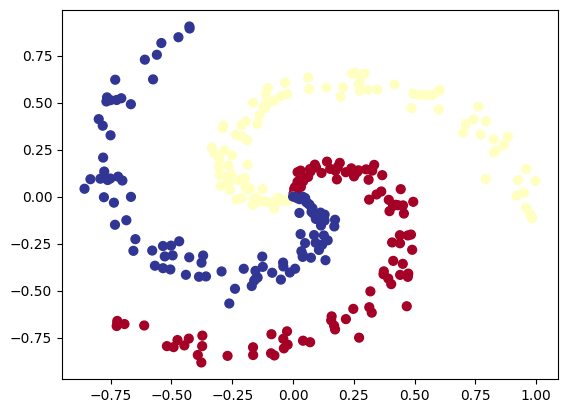

In [69]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [70]:
# Let's calculuate the accuracy for when we fit our model
# !pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [71]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module): 
  def __init__(self, in_features, out_features, hidden_features=8):
    super().__init__()
    self.linear_layer_stackV2 = nn.Sequential(
      nn.Linear(in_features=in_features, out_features=hidden_features),
      nn.ReLU(),
      nn.Linear(in_features=hidden_features, out_features=hidden_features),
      nn.ReLU(),
      nn.Linear(in_features=hidden_features, out_features=out_features)
    )

  def forward(self, x):
    return self.linear_layer_stackV2(x)

model_6 = SpiralModel(in_features=2, out_features=3).to(device)
model_6

SpiralModel(
  (linear_layer_stackV2): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [72]:
# Setup data to be device agnostic

X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.LongTensor)
X, y = X.to(device), y.to(device)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [73]:
# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
print(model_6(X_train[:10]))

# Prediction probabilities
print("Pred probs:")
print(torch.softmax(model_6(X_train)[:10], dim=1))

# Prediction labels
print("Pred labels:")
print(torch.softmax(model_6(X_train)[:10], dim=1).argmax(dim=1))

Logits:
tensor([[-0.1045,  0.3465,  0.1541],
        [-0.1025,  0.3477,  0.1547],
        [-0.1215,  0.3398,  0.1496],
        [-0.1504,  0.3543,  0.0965],
        [-0.1639,  0.3610,  0.0795],
        [-0.1350,  0.3454,  0.1283],
        [-0.1319,  0.3442,  0.1331],
        [-0.0951,  0.3521,  0.1570],
        [-0.1162,  0.3395,  0.1505],
        [-0.1500,  0.3546,  0.0962]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Pred probs:
tensor([[0.2587, 0.4062, 0.3351],
        [0.2589, 0.4062, 0.3349],
        [0.2566, 0.4070, 0.3365],
        [0.2540, 0.4208, 0.3252],
        [0.2521, 0.4262, 0.3216],
        [0.2552, 0.4126, 0.3321],
        [0.2555, 0.4114, 0.3331],
        [0.2597, 0.4061, 0.3342],
        [0.2575, 0.4062, 0.3362],
        [0.2541, 0.4209, 0.3250]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


In [74]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_6.parameters(), lr=0.1)

In [77]:
# Build a training loop for the model
epoch = 1000
# Loop over data
for epoch in range(epochs):

  ## Training
  model_6.train()
  # 1. Forward pass
  y_logits = model_6(X_train).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_6.eval()
  with torch.inference_mode():

    # 1. Forward pass
    test_logits = model_6(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)
  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss}, Acc: {acc} | Test loss: {test_loss}, Test acc: {test_acc}")

Epoch: 0 | Loss: 0.13253545761108398, Acc: 0.9541666507720947 | Test loss: 0.09902998805046082, Test acc: 0.9833333492279053
Epoch: 100 | Loss: 0.12418385595083237, Acc: 0.9541666507720947 | Test loss: 0.09045973420143127, Test acc: 0.9833333492279053
Epoch: 200 | Loss: 0.11970873177051544, Acc: 0.9541666507720947 | Test loss: 0.0860617533326149, Test acc: 0.9833333492279053
Epoch: 300 | Loss: 0.11399974673986435, Acc: 0.9583333134651184 | Test loss: 0.08074387162923813, Test acc: 0.9833333492279053
Epoch: 400 | Loss: 0.11078556627035141, Acc: 0.9541666507720947 | Test loss: 0.0782717615365982, Test acc: 0.9833333492279053
Epoch: 500 | Loss: 0.1064804419875145, Acc: 0.9541666507720947 | Test loss: 0.07397890836000443, Test acc: 0.9833333492279053
Epoch: 600 | Loss: 0.10028723627328873, Acc: 0.9666666388511658 | Test loss: 0.06820462644100189, Test acc: 0.9833333492279053
Epoch: 700 | Loss: 0.09399592131376266, Acc: 0.9708333611488342 | Test loss: 0.06189002841711044, Test acc: 0.983333

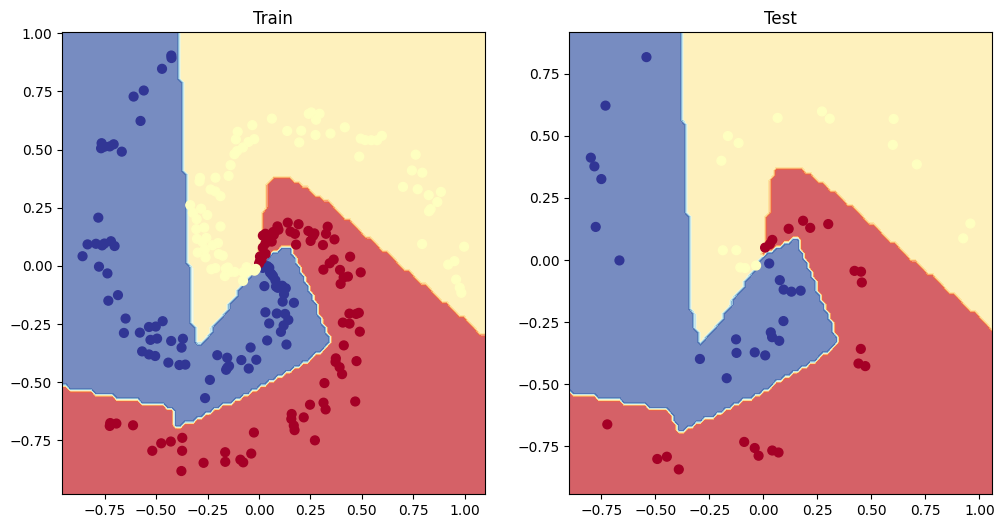

In [78]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_6, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_6, X_test, y_test)